In [2]:
%load_ext autoreload
%autoreload 

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [3]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d.io import get_tif_tag
from suite3d.io import tiff_utils as tfu
from suite3d import file_utils as flu

/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/transport.py:258: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [4]:
from suite3d import nbtools as nbui

In [5]:
subjects_dir =   '/mnt/zortex-subjects/'
expt_info = { 
    'subject':         'SS003',
    'date' :          '2024-08-16',
    'expnum' :         [1,2,3,4]}

tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False)

job_params = {    
    # number of channels recorded in the tiff file, typically 30
    'n_ch_tif' : 26,
    # number of planes in the deeper cavity, typically 15
    'cavity_size' : 13,
    # convert from the Scanimage channel ordering to deep-to-shallow ordering
    # in our case, ScanImage channel numbers are in temporal order. 
    'planes' : n.array([ 0,  2,  4,  6,  8, 10, 12, 14,
                        16, 18, 20, 22, 24, 1,  3, 5,  7,9,11, 13, 15,17,19,21])[n.array([6,7,8,9,10,11,12])],
    # number of files to use for the initial pass
    'n_init_files' :   3,
    
    # number of pixels to fuse between the ROI strips
    # the auto-detection doesn't always work well, recommend 
    # manually tuning it to reduce the stitching artifacts
    'fuse_shift_override' : 7,
    
    # will try to automatically estimate crosstalk using 
    # the shallowest crosstalk_n_planes planes. if you want to override,
    # set override_crosstalk = float between 0 and 1
    'subtract_crosstalk' : False,
    
    # volume rate in acquisition
    'fs' : flu.get_si_params(tifs[0])['vol_rate'],
    
    # 3D GPU registration - fast! 
    # for now, 3D + GPU are well-tested, other options might have minor bugs
    # if you run into them, let us know! we'll fix them
    '3d_reg' : True,
    'gpu_reg' : True,
}


job_params['fs'] = si_params['vol_rate']

savedir = os.path.join('/mnt/md0/runs', expt_info['subject'], expt_info['date'])
os.makedirs(savedir, exist_ok=True)

# Create the job
job = Job('/mnt/md0/runs',exp_str + 'subset', tifs = tifs[:20],
          params=job_params, create=True, overwrite=True, verbosity = 3)

Job directory /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset already exists
Loading job directory for SS003_2024-08-16_1-2-3-4subset in /mnt/md0/runs
   Loading dirs 
      Found dir registered_fused_data
      Found dir summary
      Found dir iters
   Loading default params
      Updating param n_ch_tif
      Updating param cavity_size
      Updating param planes
      Updating param n_init_files
      Updating param fuse_shift_override
      Updating param subtract_crosstalk
      Updating param fs
      Updating param 3d_reg
      Updating param gpu_reg
   Updated main params file


In [6]:
job.params['voxel_size_um'] = (20, 2.5, 2.5)

In [7]:
# %%time
# job.run_init_pass()

In [8]:
img3d = job.load_summary()['ref_img_3d']

In [42]:
# SAVE DATA FOR s2p Run
from suite3d.io.s3dio import s3dio
from suite3d import reference_image as ref
import tifffile

jobio = s3dio(job)

raw_data_path = '/mnt/md0/runs/s2p-SS003_2024-08-16_1-2-3-4/raw2'

os.makedirs(raw_data_path,exist_ok=True)

planes = n.array([6,7,8,9,10,11,12])
fuse_shift = 7
ys, xs = jobio._load_roi_start_pix_lbm(job.params)
for tif in job.tifs[:20]:
    print(tif)
    data = jobio.load_data([tif], planes = job.params['planes'])
    out_fname = tif.split('/')[-1].split('.')[0] + f'_{len(planes)}planes.tif'
    out_path = os.path.join(raw_data_path, out_fname)
    data = ref.fuse_mov(data, fuse_shift, xs)[0]
    data = n.swapaxes(data,0,1)        
    tifffile.imsave(out_path, data)

[{'uid': 'BD098A9831163792', 'center': array([-1.77757937,  0.        ]), 'sizeXY': array([1.8, 7.5]), 'pixXY': array([144, 600])}, {'uid': '43C88EECDEB4749B', 'center': array([0.02242063, 0.        ]), 'sizeXY': array([1.8, 7.5]), 'pixXY': array([144, 600])}, {'uid': '180496DBB23E82BB', 'center': array([1.82242064, 0.        ]), 'sizeXY': array([1.8, 7.5]), 'pixXY': array([144, 600])}, {'uid': 'C14CBB96CEFAC7A0', 'center': array([3.62242064, 0.        ]), 'sizeXY': array([1.8, 7.5]), 'pixXY': array([144, 600])}]
[  0 144 288 432]
/mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00001.tif
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00001.tif
    Loaded file into shared memory in 2.23 sec
    Workers completed in 0.95 sec
    Total time: 3.18 sec
   Loaded 1 files, total 0.45 GB
/mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00002.tif
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_

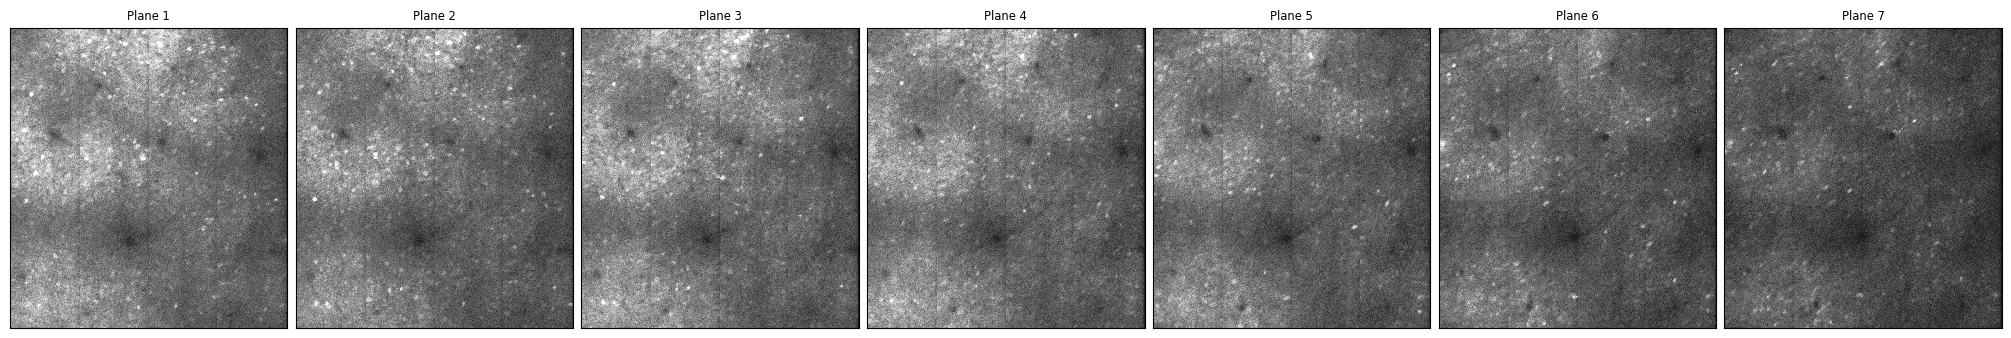

In [40]:
tfu.show_tif_all_planes(im3d, ncols=7, figsize=(20,5),vminmax=(100,5000))

In [139]:
# tfu.show_tif_all_planes(data.mean(axis=1), ncols=7, figsize=(20,5),vminmax=(100,5000))

In [140]:
# tfu.show_tif_all_planes(img3d, ncols=7, figsize=(20,5),vminmax=(100,5000))

In [93]:
%%time
job.register(tifs=job.tifs)

      Found dir /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/registered_fused_data
      Updating self.dirs tag registered_fused_data
   Saved a copy of params at /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/registered_fused_data
   Updated main params file
   Starting registration: 3D: True, GPU: True
   Overriding fuse shift value to 7
   Not clipping frames for registration
Will analyze 20 tifs in 20 batches
   Enforcing positivity
   Launching IO thread
         Memory at batch 0.  Total Used: 065.907 GB, Virtual Available: 449.068 GB, Virtual Used: 054.127 GB, Swap Used: 011.779 GB
Loading Batch 0 of 19
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00001.tif
    Loaded file into shared memory in 2.30 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.44 sec
    Total time: 3.74 sec
   Loaded 1 files, total 0.45 GB
   Batch 0 IO thread joined
         Memory after IO thread joinTotal Used: 066.401 GB, Virtual Available: 448.574 GB, Virtual Used: 054.622 GB, Swap Used: 011.779 GB
         Memory after movie copied from threadTotal Used: 066.847 GB, Virtual Available: 448.128 GB, Virtual Used: 055.067 GB, Swap Used: 011.779 GB
         Memory after thread memory clearedTotal Used: 066.400 GB, Virtual Available: 448.575 GB, Virtual Used: 054.621 GB, Swap Used: 011.779 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 066.400 GB, Virtual Available: 448.575 GB, Virtual Used: 054.621 GB, Swap Used: 011.779 GB
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00002.tif
      Loaded batch of size (7, 100, 600, 576)
   Completed rigid reg on batch in :1.280489206314087s
   Shifted the mov in: 0.3315770626068115s
         After all GPU Batches:Total 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.65 sec
    Total time: 18.59 sec
   Loaded 1 files, total 0.45 GB
   Batch 1 IO thread joined
         Memory after IO thread joinTotal Used: 068.321 GB, Virtual Available: 446.654 GB, Virtual Used: 056.542 GB, Swap Used: 011.779 GB
         Memory after movie copied from threadTotal Used: 067.845 GB, Virtual Available: 447.130 GB, Virtual Used: 056.066 GB, Swap Used: 011.779 GB
         Memory after thread memory clearedTotal Used: 067.394 GB, Virtual Available: 447.581 GB, Virtual Used: 055.614 GB, Swap Used: 011.779 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 067.394 GB, Virtual Available: 447.581 GB, Virtual Used: 055.614 GB, Swap Used: 011.779 GB
      Loaded batch of size (7, 100, 600, 576)
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00003.tif
   Completed rigid reg on batch in :1.3040626049041748s
   Shifted the mov in: 0.33170485496520996s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.74 sec
    Total time: 17.72 sec
   Loaded 1 files, total 0.45 GB
   Batch 2 IO thread joined
         Memory after IO thread joinTotal Used: 068.392 GB, Virtual Available: 446.583 GB, Virtual Used: 056.613 GB, Swap Used: 011.779 GB
         Memory after movie copied from threadTotal Used: 067.917 GB, Virtual Available: 447.058 GB, Virtual Used: 056.137 GB, Swap Used: 011.779 GB
         Memory after thread memory clearedTotal Used: 067.468 GB, Virtual Available: 447.507 GB, Virtual Used: 055.689 GB, Swap Used: 011.779 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 067.468 GB, Virtual Available: 447.507 GB, Virtual Used: 055.689 GB, Swap Used: 011.779 GB
      Loaded batch of size (7, 100, 600, 576)
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00004.tif
   Completed rigid reg on batch in :1.2785141468048096s
   Shifted the mov in: 0.33214354515075684s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.75 sec
    Total time: 17.25 sec
   Loaded 1 files, total 0.45 GB
   Batch 3 IO thread joined
         Memory after IO thread joinTotal Used: 068.422 GB, Virtual Available: 446.553 GB, Virtual Used: 056.643 GB, Swap Used: 011.779 GB
         Memory after movie copied from threadTotal Used: 067.945 GB, Virtual Available: 447.030 GB, Virtual Used: 056.166 GB, Swap Used: 011.779 GB
         Memory after thread memory clearedTotal Used: 067.492 GB, Virtual Available: 447.483 GB, Virtual Used: 055.712 GB, Swap Used: 011.779 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 067.492 GB, Virtual Available: 447.483 GB, Virtual Used: 055.712 GB, Swap Used: 011.779 GB
      Loaded batch of size (7, 100, 600, 576)
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00005.tif
   Completed rigid reg on batch in :1.2896149158477783s
   Shifted the mov in: 0.3294405937194824s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.63 sec
    Total time: 15.39 sec
   Loaded 1 files, total 0.45 GB
   Batch 4 IO thread joined
         Memory after IO thread joinTotal Used: 068.445 GB, Virtual Available: 446.530 GB, Virtual Used: 056.665 GB, Swap Used: 011.779 GB
         Memory after movie copied from threadTotal Used: 067.969 GB, Virtual Available: 447.006 GB, Virtual Used: 056.189 GB, Swap Used: 011.779 GB
         Memory after thread memory clearedTotal Used: 067.520 GB, Virtual Available: 447.455 GB, Virtual Used: 055.741 GB, Swap Used: 011.779 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 067.520 GB, Virtual Available: 447.455 GB, Virtual Used: 055.741 GB, Swap Used: 011.779 GB
      Loaded batch of size (7, 100, 600, 576)
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00006.tif
   Completed rigid reg on batch in :1.261925220489502s
   Shifted the mov in: 0.32038450241088867s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.66 sec
    Total time: 14.81 sec
   Loaded 1 files, total 0.45 GB
   Batch 5 IO thread joined
         Memory after IO thread joinTotal Used: 068.474 GB, Virtual Available: 446.502 GB, Virtual Used: 056.694 GB, Swap Used: 011.779 GB
         Memory after movie copied from threadTotal Used: 067.997 GB, Virtual Available: 446.978 GB, Virtual Used: 056.218 GB, Swap Used: 011.779 GB
         Memory after thread memory clearedTotal Used: 067.543 GB, Virtual Available: 447.432 GB, Virtual Used: 055.763 GB, Swap Used: 011.779 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 067.543 GB, Virtual Available: 447.432 GB, Virtual Used: 055.763 GB, Swap Used: 011.779 GB
      Loaded batch of size (7, 100, 600, 576)
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00007.tif
   Completed rigid reg on batch in :1.2598915100097656s
   Shifted the mov in: 0.317197322845459s
         After all GPU Batches:Total

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.79 sec
    Total time: 16.07 sec
   Loaded 1 files, total 0.45 GB
   Batch 6 IO thread joined
         Memory after IO thread joinTotal Used: 068.567 GB, Virtual Available: 446.408 GB, Virtual Used: 056.788 GB, Swap Used: 011.779 GB
         Memory after movie copied from threadTotal Used: 068.090 GB, Virtual Available: 446.885 GB, Virtual Used: 056.311 GB, Swap Used: 011.779 GB
         Memory after thread memory clearedTotal Used: 068.472 GB, Virtual Available: 446.503 GB, Virtual Used: 056.693 GB, Swap Used: 011.779 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 068.476 GB, Virtual Available: 446.499 GB, Virtual Used: 056.697 GB, Swap Used: 011.779 GB
      Loaded batch of size (7, 100, 600, 576)
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00008.tif
   Completed rigid reg on batch in :1.2890827655792236s
   Shifted the mov in: 0.319568395614624s
         After all GPU Batches:Total

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.95 sec
    Total time: 17.06 sec
   Loaded 1 files, total 0.45 GB
   Batch 7 IO thread joined
         Memory after IO thread joinTotal Used: 068.544 GB, Virtual Available: 446.431 GB, Virtual Used: 056.765 GB, Swap Used: 011.779 GB
         Memory after movie copied from threadTotal Used: 068.070 GB, Virtual Available: 446.905 GB, Virtual Used: 056.291 GB, Swap Used: 011.779 GB
         Memory after thread memory clearedTotal Used: 067.623 GB, Virtual Available: 447.352 GB, Virtual Used: 055.843 GB, Swap Used: 011.779 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 067.619 GB, Virtual Available: 447.356 GB, Virtual Used: 055.840 GB, Swap Used: 011.779 GB
      Loaded batch of size (7, 100, 600, 576)
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00009.tif
   Completed rigid reg on batch in :1.2819850444793701s
   Shifted the mov in: 0.3438403606414795s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.83 sec
    Total time: 17.34 sec
   Loaded 1 files, total 0.45 GB
   Batch 8 IO thread joined
         Memory after IO thread joinTotal Used: 068.546 GB, Virtual Available: 446.429 GB, Virtual Used: 056.767 GB, Swap Used: 011.779 GB
         Memory after movie copied from threadTotal Used: 068.061 GB, Virtual Available: 446.914 GB, Virtual Used: 056.281 GB, Swap Used: 011.779 GB
         Memory after thread memory clearedTotal Used: 067.613 GB, Virtual Available: 447.362 GB, Virtual Used: 055.834 GB, Swap Used: 011.779 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 067.613 GB, Virtual Available: 447.362 GB, Virtual Used: 055.834 GB, Swap Used: 011.779 GB
      Loaded batch of size (7, 100, 600, 576)
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00010.tif
   Completed rigid reg on batch in :1.2668850421905518s
   Shifted the mov in: 0.34429407119750977s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.68 sec
    Total time: 18.22 sec
   Loaded 1 files, total 0.45 GB
   Batch 9 IO thread joined
         Memory after IO thread joinTotal Used: 068.574 GB, Virtual Available: 446.401 GB, Virtual Used: 056.794 GB, Swap Used: 011.779 GB
         Memory after movie copied from threadTotal Used: 068.096 GB, Virtual Available: 446.879 GB, Virtual Used: 056.317 GB, Swap Used: 011.779 GB
         Memory after thread memory clearedTotal Used: 067.641 GB, Virtual Available: 447.334 GB, Virtual Used: 055.862 GB, Swap Used: 011.779 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 067.641 GB, Virtual Available: 447.334 GB, Virtual Used: 055.862 GB, Swap Used: 011.779 GB
      Loaded batch of size (7, 100, 600, 576)
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00011.tif
   Completed rigid reg on batch in :1.2726120948791504s
   Shifted the mov in: 0.3454110622406006s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.80 sec
    Total time: 18.48 sec
   Loaded 1 files, total 0.45 GB
   Batch 10 IO thread joined
         Memory after IO thread joinTotal Used: 068.546 GB, Virtual Available: 446.429 GB, Virtual Used: 056.767 GB, Swap Used: 011.779 GB
         Memory after movie copied from threadTotal Used: 068.070 GB, Virtual Available: 446.905 GB, Virtual Used: 056.291 GB, Swap Used: 011.779 GB
         Memory after thread memory clearedTotal Used: 067.615 GB, Virtual Available: 447.360 GB, Virtual Used: 055.836 GB, Swap Used: 011.779 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 067.614 GB, Virtual Available: 447.361 GB, Virtual Used: 055.835 GB, Swap Used: 011.779 GB
      Loaded batch of size (7, 100, 600, 576)
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00012.tif
   Completed rigid reg on batch in :1.282649278640747s
   Shifted the mov in: 0.34008097648620605s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.74 sec
    Total time: 18.94 sec
   Loaded 1 files, total 0.45 GB
   Batch 11 IO thread joined
         Memory after IO thread joinTotal Used: 068.535 GB, Virtual Available: 446.440 GB, Virtual Used: 056.756 GB, Swap Used: 011.779 GB
         Memory after movie copied from threadTotal Used: 068.060 GB, Virtual Available: 446.916 GB, Virtual Used: 056.280 GB, Swap Used: 011.779 GB
         Memory after thread memory clearedTotal Used: 067.602 GB, Virtual Available: 447.373 GB, Virtual Used: 055.822 GB, Swap Used: 011.779 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 067.601 GB, Virtual Available: 447.374 GB, Virtual Used: 055.822 GB, Swap Used: 011.779 GB
      Loaded batch of size (7, 100, 600, 576)
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00013.tif
   Completed rigid reg on batch in :1.2740800380706787s
   Shifted the mov in: 0.3258843421936035s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.73 sec
    Total time: 9.19 sec
   Loaded 1 files, total 0.45 GB
   Batch 12 IO thread joined
         Memory after IO thread joinTotal Used: 068.535 GB, Virtual Available: 446.440 GB, Virtual Used: 056.756 GB, Swap Used: 011.779 GB
         Memory after movie copied from threadTotal Used: 068.058 GB, Virtual Available: 446.917 GB, Virtual Used: 056.279 GB, Swap Used: 011.779 GB
         Memory after thread memory clearedTotal Used: 067.606 GB, Virtual Available: 447.369 GB, Virtual Used: 055.827 GB, Swap Used: 011.779 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 067.606 GB, Virtual Available: 447.369 GB, Virtual Used: 055.827 GB, Swap Used: 011.779 GB
      Loaded batch of size (7, 100, 600, 576)
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00014.tif
   Completed rigid reg on batch in :1.274111032485962s
   Shifted the mov in: 0.3347609043121338s
         After all GPU Batches:Total

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.71 sec
    Total time: 8.83 sec
   Loaded 1 files, total 0.45 GB
   Batch 13 IO thread joined
         Memory after IO thread joinTotal Used: 068.512 GB, Virtual Available: 446.463 GB, Virtual Used: 056.732 GB, Swap Used: 011.779 GB
         Memory after movie copied from threadTotal Used: 068.027 GB, Virtual Available: 446.948 GB, Virtual Used: 056.248 GB, Swap Used: 011.779 GB
         Memory after thread memory clearedTotal Used: 067.902 GB, Virtual Available: 447.074 GB, Virtual Used: 056.122 GB, Swap Used: 011.779 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 067.903 GB, Virtual Available: 447.072 GB, Virtual Used: 056.124 GB, Swap Used: 011.779 GB
      Loaded batch of size (7, 100, 600, 576)
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00015.tif
   Completed rigid reg on batch in :1.2674283981323242s
   Shifted the mov in: 0.33685898780822754s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.76 sec
    Total time: 9.38 sec
   Loaded 1 files, total 0.45 GB
   Batch 14 IO thread joined
         Memory after IO thread joinTotal Used: 069.534 GB, Virtual Available: 445.441 GB, Virtual Used: 057.755 GB, Swap Used: 011.779 GB
         Memory after movie copied from threadTotal Used: 069.367 GB, Virtual Available: 445.608 GB, Virtual Used: 057.587 GB, Swap Used: 011.779 GB
         Memory after thread memory clearedTotal Used: 069.421 GB, Virtual Available: 445.554 GB, Virtual Used: 057.642 GB, Swap Used: 011.779 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 069.422 GB, Virtual Available: 445.553 GB, Virtual Used: 057.643 GB, Swap Used: 011.779 GB
      Loaded batch of size (7, 100, 600, 576)
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00016.tif
   Completed rigid reg on batch in :1.25398850440979s
   Shifted the mov in: 0.3338794708251953s
         After all GPU Batches:Total 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.67 sec
    Total time: 10.89 sec
   Loaded 1 files, total 0.45 GB
   Batch 15 IO thread joined
         Memory after IO thread joinTotal Used: 072.214 GB, Virtual Available: 442.761 GB, Virtual Used: 060.434 GB, Swap Used: 011.779 GB
         Memory after movie copied from threadTotal Used: 071.793 GB, Virtual Available: 443.182 GB, Virtual Used: 060.013 GB, Swap Used: 011.779 GB
         Memory after thread memory clearedTotal Used: 071.444 GB, Virtual Available: 443.531 GB, Virtual Used: 059.664 GB, Swap Used: 011.779 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 071.444 GB, Virtual Available: 443.531 GB, Virtual Used: 059.664 GB, Swap Used: 011.779 GB
      Loaded batch of size (7, 100, 600, 576)
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00017.tif
   Completed rigid reg on batch in :1.2971527576446533s
   Shifted the mov in: 0.3315572738647461s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.63 sec
    Total time: 11.32 sec
   Loaded 1 files, total 0.45 GB
   Batch 16 IO thread joined
         Memory after IO thread joinTotal Used: 069.133 GB, Virtual Available: 445.842 GB, Virtual Used: 057.354 GB, Swap Used: 011.779 GB
         Memory after movie copied from threadTotal Used: 067.671 GB, Virtual Available: 447.304 GB, Virtual Used: 055.891 GB, Swap Used: 011.779 GB
         Memory after thread memory clearedTotal Used: 068.017 GB, Virtual Available: 446.958 GB, Virtual Used: 056.237 GB, Swap Used: 011.779 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 068.019 GB, Virtual Available: 446.957 GB, Virtual Used: 056.239 GB, Swap Used: 011.779 GB
      Loaded batch of size (7, 100, 600, 576)
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00018.tif
   Completed rigid reg on batch in :1.266601800918579s
   Shifted the mov in: 0.33717966079711914s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.79 sec
    Total time: 11.79 sec
   Loaded 1 files, total 0.45 GB
   Batch 17 IO thread joined
         Memory after IO thread joinTotal Used: 068.547 GB, Virtual Available: 446.428 GB, Virtual Used: 056.767 GB, Swap Used: 011.779 GB
         Memory after movie copied from threadTotal Used: 068.102 GB, Virtual Available: 446.873 GB, Virtual Used: 056.323 GB, Swap Used: 011.779 GB
         Memory after thread memory clearedTotal Used: 067.609 GB, Virtual Available: 447.366 GB, Virtual Used: 055.830 GB, Swap Used: 011.779 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 067.609 GB, Virtual Available: 447.366 GB, Virtual Used: 055.830 GB, Swap Used: 011.779 GB
      Loaded batch of size (7, 100, 600, 576)
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00019.tif
   Completed rigid reg on batch in :1.282641887664795s
   Shifted the mov in: 0.3437614440917969s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.82 sec
    Total time: 12.20 sec
   Loaded 1 files, total 0.45 GB
   Batch 18 IO thread joined
         Memory after IO thread joinTotal Used: 068.529 GB, Virtual Available: 446.446 GB, Virtual Used: 056.750 GB, Swap Used: 011.779 GB
         Memory after movie copied from threadTotal Used: 068.052 GB, Virtual Available: 446.923 GB, Virtual Used: 056.272 GB, Swap Used: 011.779 GB
         Memory after thread memory clearedTotal Used: 067.601 GB, Virtual Available: 447.374 GB, Virtual Used: 055.821 GB, Swap Used: 011.779 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 067.602 GB, Virtual Available: 447.373 GB, Virtual Used: 055.822 GB, Swap Used: 011.779 GB
      Loaded batch of size (7, 100, 600, 576)
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00020.tif
   Completed rigid reg on batch in :1.2750201225280762s
   Shifted the mov in: 0.34612536430358887s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.79 sec
    Total time: 12.04 sec
   Loaded 1 files, total 0.45 GB
   Batch 19 IO thread joined
         Memory after IO thread joinTotal Used: 068.550 GB, Virtual Available: 446.425 GB, Virtual Used: 056.771 GB, Swap Used: 011.779 GB
         Memory after movie copied from threadTotal Used: 068.073 GB, Virtual Available: 446.902 GB, Virtual Used: 056.294 GB, Swap Used: 011.779 GB
         Memory after thread memory clearedTotal Used: 067.618 GB, Virtual Available: 447.357 GB, Virtual Used: 055.838 GB, Swap Used: 011.779 GB
      Loaded batch of size (7, 100, 600, 576)
   Completed rigid reg on batch in :1.2671258449554443s
   Shifted the mov in: 0.35042381286621094s
         After all GPU Batches:Total Used: 069.030 GB, Virtual Available: 445.945 GB, Virtual Used: 057.250 GB, Swap Used: 011.779 GB
      Saving fused, registered file of shape (7, 100, 616, 579) to /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/registered_fused_data/fused_reg_data0019.npy
   

In [106]:
mov = job.get_registered_movie()a

In [145]:
reg = job.load_registration_results()

In [146]:
reg.keys()

dict_keys(['phase_corr_shifted', 'int_shift', 'pc_peak_loc', 'sub_pixel_shifts'])

In [ ]:
qm = job.

In [107]:
%%time
job.params['voxel_size_um'] = (20, 2.5, 2.5)
job.params['npil_filt_type'] = 'unif'
job.params['npil_filt_xy_um'] = 200

job.params['cell_filt_type'] = 'gaussian'
job.params['cell_filt_xy_um'] = 5
job.params['sdnorm_exp'] = 0.85
job.params['intensity_thresh'] = 1.0 # original run with 0.1
corr_map = job.calculate_corr_map()

      Found dir /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/corrmap
      Updating self.dirs tag corrmap
      Found dir /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/mov_sub
      Updating self.dirs tag mov_sub
   Saved a copy of params at /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/corrmap
   Updated main params file
   Computing correlation map of movie with 2000 frames, volume shape: 7, 616, 579
      Running batch 1 of 10
         Timer prep completed in 1.089 sec
         Timer batch_setup completed in 0.450 sec
         Timer batch_edgecrop completed in 0.040 sec
         Timer accum_meanmeax completed in 0.381 sec
         Timer batch_rolling_mean_filt completed in 0.359 sec
         Timer batch_accum_sdmov completed in 1.107 sec
         Timer batch_norm_sdmov completed in 0.184 sec
         Loading movie into shared memory
         Timer dtu_shmem completed in 1.460 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d comple

In [108]:
corr_map = job.load_corr_map_results()['vmap']

In [109]:
from suite3d import extension as ext

In [110]:
corr_map_thresh = ext.thresh_mask_corr_map(corr_map, thresh_window_size_pix = 51, corrmap_thresh_pct = 50)

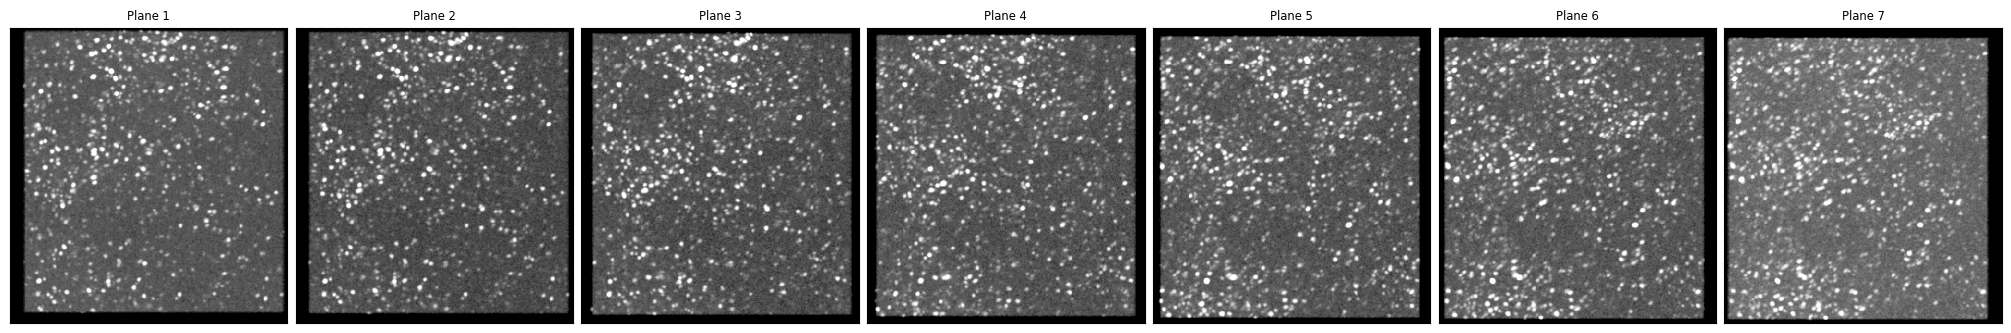

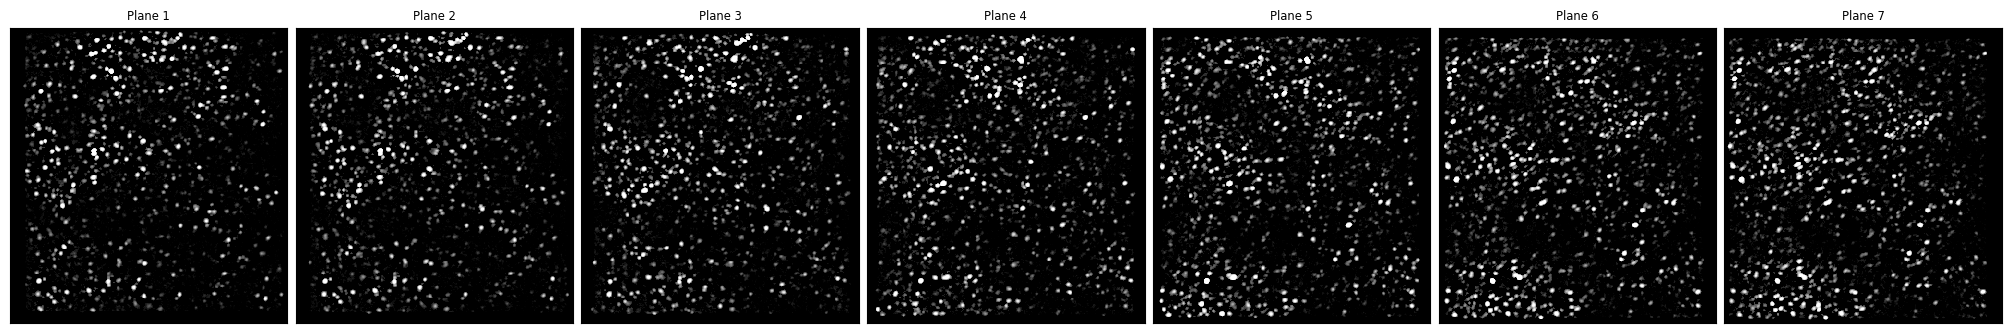

In [111]:
tfu.show_tif_all_planes(corr_map, ncols=7, figsize=(20,5))
tfu.show_tif_all_planes(corr_map_thresh, ncols=7, figsize=(20,5))

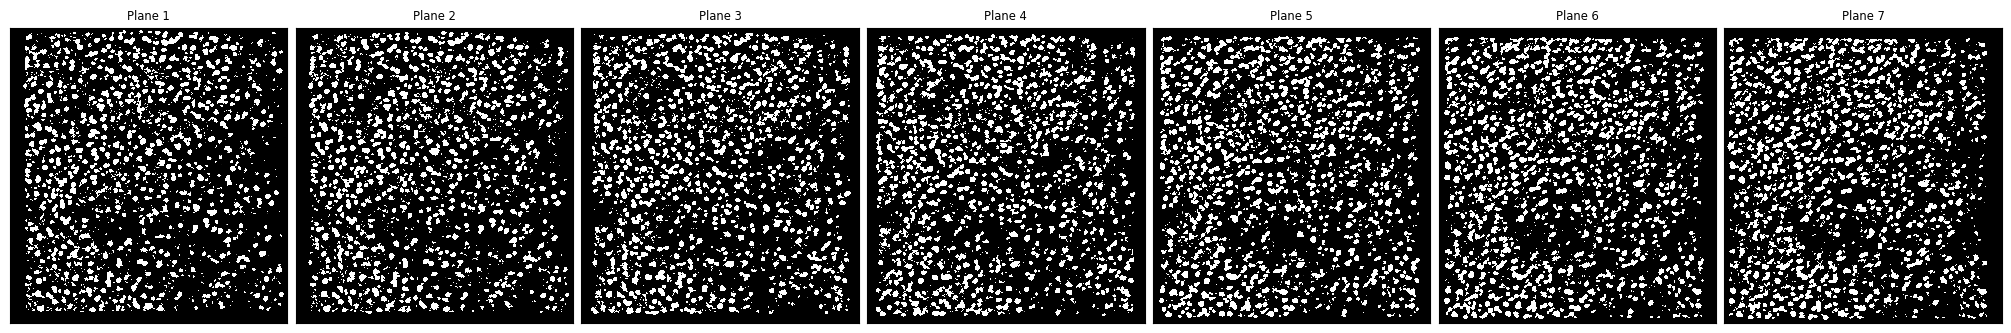

In [112]:

tfu.show_tif_all_planes(corr_map_thresh, ncols=7, figsize=(20,5), vminmax=(0.02,0.021))

(120, 120)

In [116]:
mov.shape

(7, 2000, 616, 579)

In [117]:
%%time
job.params['peak_thresh'] = 0.02
# optionally, bin the movie in time to speed up detection
# probably a good idea if you have high framerate (>5 Hz?)
job.params['detection_timebin'] = 1 

# when extending an ROI, compare its activity to its neighboring pixels
# in frames where the fluorescence is above this percentile
job.params['percentile'] = 99.0

job.params['extend_thresh'] = 0.05
job.params['activity_thresh'] = 5.0
job.params['max_iter'] = 1000
job.params['ext_subtract_iters'] = 3
job.params['n_proc_detect'] = 64
job.params['patch_size_xy'] = (250, 250)

# corr_map = job.load_corr_map_results()['vmap']
job.segment_rois(vmap=corr_map_thresh)

      Found dir /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/segmentation
      Updating self.dirs tag segmentation
   Saved a copy of params at /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/segmentation
   Updated main params file
      Found dir /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/rois
      Updating self.dirs tag rois
   Saving results to /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/segmentation and /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/rois 
dict_keys(['max_img', 'mean_img', 'vmap', 'all_params'])
   Detecting from patch 1 / 9
      Found dir /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/segmentation/patch-0000
         Loading 3.26 GB movie to memory, shape: (2000, 7, 250, 250) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.020 and Th2: 5.000
         Iter 0000: running 64 ROIs in parallel
         Added cell 1 at 00, 040, 205, peak: 1.044, thresh: 5.000, 396 frames,

'/mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/rois'

In [118]:
job.compute_npil_masks(stats_dir = job.dirs['rois'])

traces = job.extract_and_deconvolve(stats_dir=job.dirs['rois'])
job.export_results('/mnt/zeytin-f1/s3d-results/',result_dir_name='rois')#, additional_info = job.load_corr_map_results())

   Updated main params file
   Movie shape: (7, 2000, 616, 579)
7925
   Extracting 7925 valid cells, and saving cell flags to /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/rois/iscell_extracted.npy
   Extracting activity
         Will extract in 4 batches of 500
Saving intermediate results to /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/rois
            Extracting batch 0000 of 0004
            Batch size: 4 GB
            Extracting batch 0001 of 0004
            Batch size: 4 GB
            Extracting batch 0002 of 0004
            Batch size: 4 GB
            Extracting batch 0003 of 0004
            Batch size: 4 GB
   Deconvolving
   Saving to /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/rois
   Created dir /mnt/zeytin-f1/s3d-results/s3d-results-SS003_2024-08-16_1-2-3-4subset to export results
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/rois/stats_small.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/rois/info.npy
      Lo

In [119]:
reg = job.load_registration_results()

In [120]:
shifts = n.concatenate(reg['int_shift'],axis=0)
sp_shifts = n.concatenate(reg['sub_pixel_shifts'], axis=0)

(0.0, 100.0)

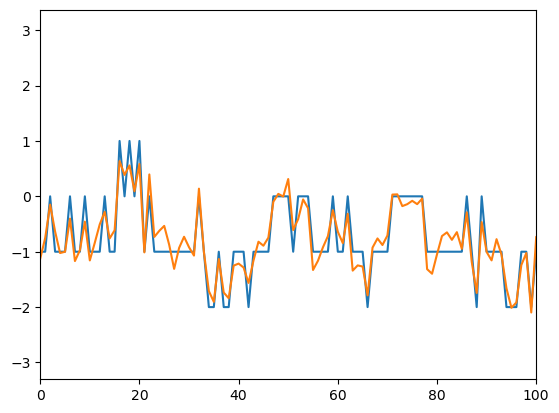

In [121]:
plt.plot(shifts[:,2])
plt.plot(sp_shifts[:,2])
plt.xlim(0,100)

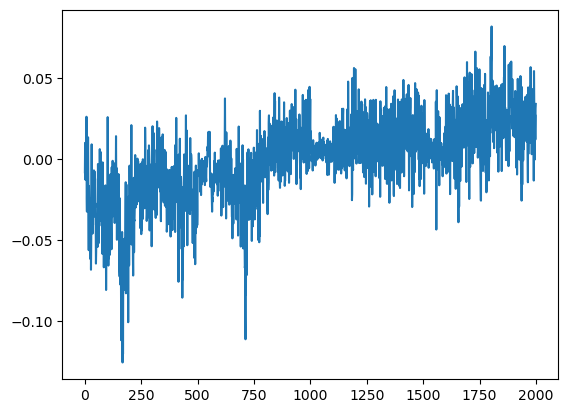

In [122]:
plt.plot(sp_shifts[:,0])